# Binary Classification Exercise using Keras & Tensorflow

We will try to identify if the turbine **T01** in EDP wind farm is in the rated region (max. power production region), using the wind speed time series extracted from its SCADA.

<br> **Below_rated** $\rightarrow$ 0
<br> **Rated** $\rightarrow$ 1

 <img src="https://i.imgur.com/CjJLXQt.png" alt="Drawing" style="float: left; width: 1500px;" /> 


As you can see from the power curve, the definition of the rated region is not so straight-forward. We will see how well we can predict if the turbine will be at its maximum capacity (given the wind speed statistics) using deep learning.

We will use a subset of the EDP SCADA series, **Data_TimeSeriesClassification.csv** file for this exercise.

# First thing is to load the data 

Let's go pandas - watch for delimiter & 'non-data' text in the beginning

In [1]:
import pandas as pd

file = 'Data_TimeSeriesClassification.csv'
dataset = pd.read_csv(file,  delimiter=';')
dataset.head()

,Turbine_ID,Timestamp,Amb_WindSpeed_Max,Amb_WindSpeed_Min,Amb_WindSpeed_Avg,Amb_WindSpeed_Std,Rated
0,T01,2017-01-13 03:40:00+00:00,8.06,0.05,3.04,0.08,0
1,T07,2017-01-13 03:50:00+00:00,10.05,0.06,3.05,0.09,0
2,T07,2017-01-13 04:40:00+00:00,6.03,0.04,2.06,0.06,0
3,T07,2017-01-13 05:00:00+00:00,8.05,0.04,2.05,0.08,0
4,T11,2017-01-13 05:30:00+00:00,9.04,0.06,4.03,1.01,0


### Convert date strings to 'pandas date'  and change our index to time stamps 

1. We should first clear the repetitive 'time zone' information --> '+00:00'

*Note that '+' is a special character, we will escape it with '\+00:00'*

2. Then we will convert it to date-time object and define it as our index then sort with respect to timestamps

In [2]:
dataset.Timestamp = dataset.Timestamp.str.replace('+00:00', '')

dataset.Timestamp = pd.to_datetime(dataset.Timestamp)
dataset.set_index('Timestamp', inplace=True)
dataset.sort_index(inplace=True)
dataset


,Turbine_ID,Amb_WindSpeed_Max,Amb_WindSpeed_Min,Amb_WindSpeed_Avg,Amb_WindSpeed_Std,Rated
Timestamp,,,,,,
2017-01-01 00:10:00,T11,14.00,1.07,6.07,1.02,0
2017-01-01 00:20:00,T11,12.08,2.01,7.05,1.02,0
2017-01-01 00:30:00,T06,8.07,2.07,5.04,0.07,0
2017-01-01 00:40:00,T07,9.01,1.06,5.04,1.00,0
2017-01-01 00:50:00,T07,10.02,1.02,4.06,0.09,0
...,...,...,...,...,...,...
2017-12-31 23:10:00,T01,7.03,5.01,6.03,0.05,0
2017-12-31 23:20:00,T01,7.08,4.07,6.04,0.06,0
2017-12-31 23:30:00,T07,9.01,2.01,5.01,0.08,0


## Extract data for the turbine in question : T01

We will index the dataframe based on the values on column Turbine_ID

In [3]:
dataset_T01 = dataset[dataset.Turbine_ID == 'T01']
dataset_T01

,Turbine_ID,Amb_WindSpeed_Max,Amb_WindSpeed_Min,Amb_WindSpeed_Avg,Amb_WindSpeed_Std,Rated
Timestamp,,,,,,
2017-01-01 01:50:00,T01,11.02,2.01,5.08,0.09,0
2017-01-01 02:30:00,T01,13.00,0.07,8.02,1.02,0
2017-01-01 02:50:00,T01,11.01,3.06,7.07,0.09,0
2017-01-01 03:30:00,T01,12.09,4.01,8.01,1.00,0
2017-01-01 04:00:00,T01,14.06,3.04,8.03,1.01,0
...,...,...,...,...,...,...
2017-12-31 22:50:00,T01,7.04,4.07,5.09,0.05,0
2017-12-31 23:00:00,T01,7.07,4.08,6.04,0.06,0
2017-12-31 23:10:00,T01,7.03,5.01,6.03,0.05,0


## 'Real-data' might have missing values and time stamps  (a.k.a. periods of missing data) - we should always check

### via explicit listing : pd.date_range().difference()


In [4]:
print('Null values: ', dataset_T01.isnull().sum())

missing_time_stamps = pd.date_range(start=dataset_T01.index[0],
                                    end=dataset_T01.index[-1], 
                                    freq='10min').difference(dataset_T01.index)

print('Missing time stamps ', missing_time_stamps)

Null values:  Turbine_ID           0
Amb_WindSpeed_Max    0
Amb_WindSpeed_Min    0
Amb_WindSpeed_Avg    0
Amb_WindSpeed_Std    0
Rated                0
dtype: int64
Missing time stamps  DatetimeIndex(['2017-01-01 02:00:00', '2017-01-01 02:10:00',
               '2017-01-01 02:20:00', '2017-01-01 02:40:00',
               '2017-01-01 03:00:00', '2017-01-01 03:10:00',
               '2017-01-01 03:20:00', '2017-01-01 03:40:00',
               '2017-01-01 03:50:00', '2017-01-01 04:10:00',
               ...
               '2017-12-31 21:00:00', '2017-12-31 21:10:00',
               '2017-12-31 21:20:00', '2017-12-31 21:30:00',
               '2017-12-31 21:50:00', '2017-12-31 22:00:00',
               '2017-12-31 22:10:00', '2017-12-31 22:20:00',
               '2017-12-31 22:40:00', '2017-12-31 23:30:00'],
              dtype='datetime64[ns]', length=44382, freq=None)


### or direct nan placement : df.resample(sampling_rate).asfreq()


In [5]:
sampling_rate = '10min' # we have 10min resolution in our dataset
dataset_T01_cont = dataset_T01.resample(sampling_rate).asfreq()
dataset_T01_cont.loc[missing_time_stamps]

,Turbine_ID,Amb_WindSpeed_Max,Amb_WindSpeed_Min,Amb_WindSpeed_Avg,Amb_WindSpeed_Std,Rated
2017-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:20:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:40:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2017-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 22:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 22:20:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 22:40:00,NaN,NaN,NaN,NaN,NaN,NaN


### Visualization of the time-series can also be very helpful to illustrate the missing data

Let's check the mean wind speed time series

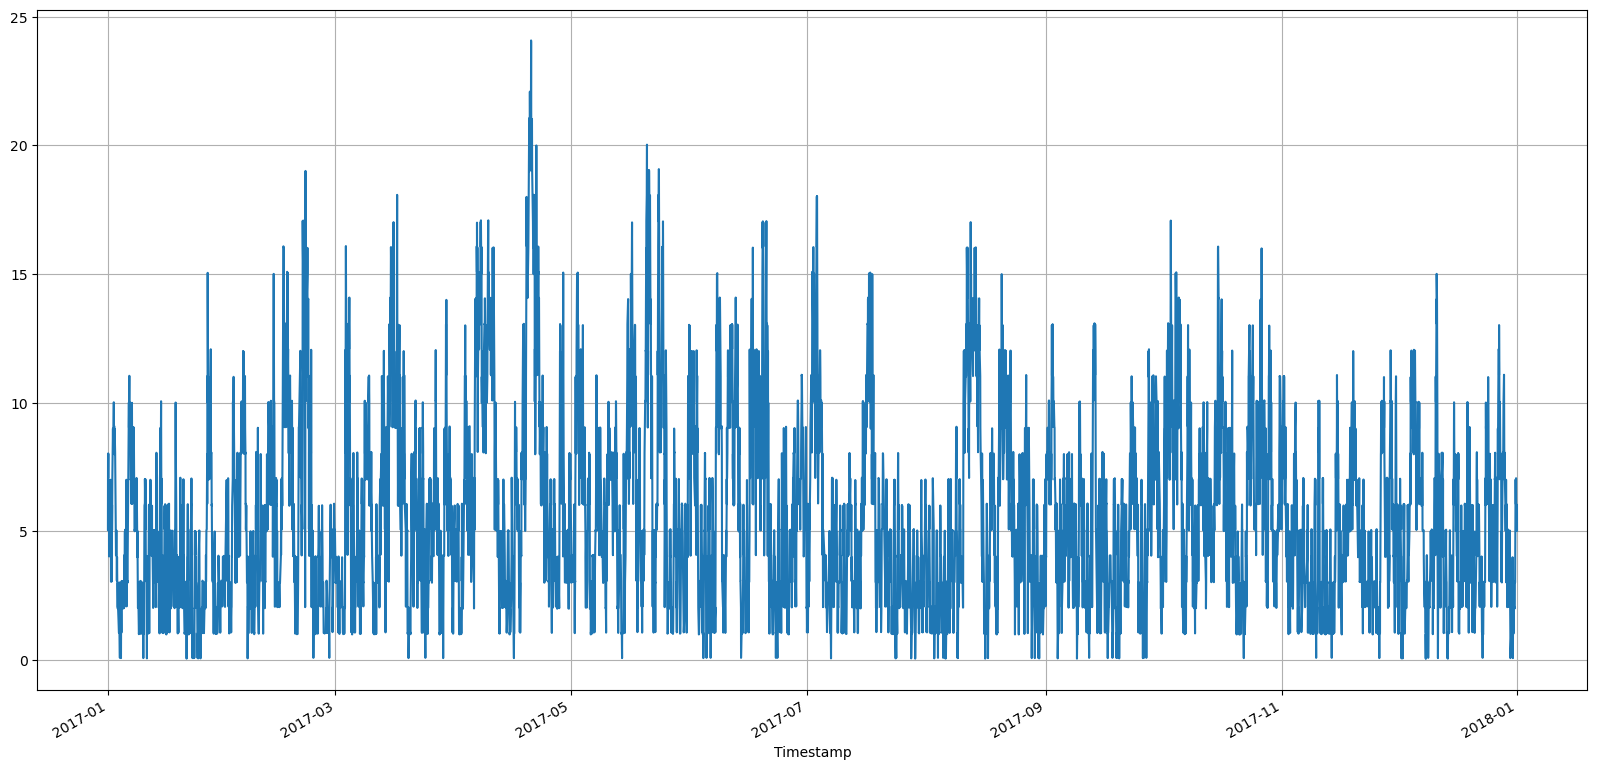

In [6]:
import matplotlib.pyplot as plt

dataset_T01.Amb_WindSpeed_Avg.plot(subplots=True, figsize=(20,10), grid=True)
plt.show()

# Define input and output datasets

The produced power at a turbine is highly correlated to the wind speed: 

\begin{equation}
Power = \frac{1}{2} \rho C_p A U^3 
\end{equation}

where:
<br> $\rho$ is the air density, 
<br> $C_p$ is the power coefficient (specific to the turbine model),
<br> $A$ is the area of the turbine rotor, and
<br> $U$ is the wind speed. 

Let's define a single input model (for now).
***
INPUTS:   
   1. Mean Wind Speed $\rightarrow$ **Amb_WindSpeed_Avg**
   2. Standard deviation of Wind Speed $\rightarrow$ **Amb_WindSpeed_Std**

OUTPUT:
   1. The 'Rated' class
       1. **Below_rated** $\rightarrow$ **0**   
       2. **Rated** $\rightarrow$ **1**  




In [7]:
# Choose the input and output features from the main dataframe
# Note that the index is a datetime object - you might consider converting the dataframe to arrays using df.values

X = dataset_T01[['Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std']].values
Y = dataset_T01[['Rated']].values

print(X.shape)
print(Y.shape)

(8166, 2)
(8166, 1)


## Seperate Training, Validation and Test datasets
In order to validate of our model, we need to evaluate it on a new (or independent) dataset. Accordingly, we
will separate our data into train, validation and test datasets for training, tuning and evaluation of our model. Following the general practice, we will use 60% of the data for training, 20% for validation and 20% for final testing the trained model

In [8]:
import numpy as np

train_int = int(0.6*len(dataset_T01)) # 60% of the data length for training
validation_int = int(0.8*len(dataset_T01)) # 20% more for validation

# training input vector
X_train = X[:train_int,:]

# training output vector
Y_train = Y[:train_int,:]        

# validation input vector
X_validation = X[train_int:validation_int,:]

# validation output vector
Y_validation = Y[train_int:validation_int,:]

# test input vector
X_test = X[validation_int:,:]

# test output vector
Y_test = Y[validation_int:,:]


## Scale (or Normalize) the data

It is very important for our problem that the inputs are normalized. This is mainly due to the fact that the Wind Speed, and its standard deviations have different 'value ranges' or scales. Not scaling the data beforehand might cause inefficient weights and bias in our learning.

To be able to estimate the weights and biases properly for our model, we need to normalize all the inputs. Here, since negative values are not expected, we are scaling our data between 0 and 1. We will use scikit-learn preprocessing library for that.

Printing the scaled data shows the considered values are rather similar now.

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

X_train_scaled

array([[0.20899251, 0.01980198],
       [0.33139051, 0.25      ],
       [0.29184013, 0.01980198],
       ...,
       [0.45628643, 0.4950495 ],
       [0.45711907, 0.49752475],
       [0.49708576, 0.5       ]])

# Define the Model to train

We create a Sequential, feed-forward model and add layers one at a time until we are happy with our network topology.

The first thing to get right is to ensure the input layer has the right number of inputs. We can specify that when creating the first layer with the input_dim argument and setting to the number of our input variables.

### How do we know the 'best' number of layers and their types?

This is a very hard question. There are heuristics that we can use and often the best network structure is found through a process of trial and error experimentation. Generally speaking, you need a network large enough to capture the structure of the problem. 

In this example, we will use a **fully-connected network structure with 2 hidden layers and an output layer**, to begin with.

Fully connected layers are defined using the Dense class. We can specify the number of neurons in the layer as the first argument, the initialization method as the second argument as init and specify the activation function using the activation argument.

### Initialization of Weights and Biases
The initalization for the weights and biases (as all the features of Keras) is well documented here: https://keras.io/initializers/ 
<br>In our case, we initialize the network weights to a small random number generated from a uniform distribution (‘uniform‘), in this case between 0 and 0.05 because that is the default uniform weight initialization in Keras. Another traditional alternative would be ‘normal’ for small random numbers generated from a Gaussian distribution.

### Activation Functions
When we do not have the activation function the weights and bias would simply do a linear transformation. A linear equation is simple to solve but is limited in its capacity to solve complex problems. The activation function does the non-linear transformation to the input making it capable to learn and perform more complex tasks.

There are many activation functions available in Keras https://keras.io/activations/. 
The most-widely used ones are listed below:

   1. **sigmoid** $\rightarrow$ logistic & non-linear 
<br> 

<img src="https://cdn-images-1.medium.com/max/1600/1*Xu7B5y9gp0iL5ooBj7LtWw.png" alt="Drawing" style="float: left; width: 300px;" />

As seen, the sigmoid function is defined between (0 to 1). Accordingly, it is especially useful for probability prediction/modelling.Since probability of anything exists only between the range of 0 and 1, sigmoid is the right choice where probability is the output. However, the logistic sigmoid function can cause a neural network to get stuck at the training time.
Therefore, softmax function is a more generalized logistic activation function which is used for multiclass classification.
<br>
<br>
<br>
<br>
  <br>2. **softmax** $\rightarrow$ generalization of the logistic function
  
<img src="https://themaverickmeerkat.com/img/softmax/softmax_2d.png" alt="Drawing" style="float: left; width: 300px;" /> 

Similar to Sigmoid, the calculated probabilities via Softmax function will be in the range of 0 to 1. Additionally, Softmax assembles actual classes to 1 - ensures that the sum of all the probabilities is equal to 1. For more detailed explanation on sigmoid and softmax, including their mathematical representations, see https://themaverickmeerkat.com/2019-10-23-Softmax/
<br>
<br>
<br>
<br>
<br>
<br>
   <br>3. **tanh** $\rightarrow$ non-linear, also covers negative range    
 <img src="https://i2.wp.com/sefiks.com/wp-content/uploads/2017/01/tanh.png?resize=456%2C300&ssl=1" alt="Drawing" style="float: left; width: 300px;" /> 

tanh is also sigmoidal (s - shaped) but the range of the tanh function is from (-1 to 1). That enables to map negative inputs as well. The tanh function is mainly used for classification problems between two classes. 
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
   <br>4. **relu (Rectified Linear Unit)** $\rightarrow$ also non-linear, also covers negative range   
<img src="https://www.researchgate.net/profile/Leo-Pauly/publication/319235847/figure/fig3/AS:537056121634820@1505055565670/ReLU-activation-function.png" alt="Drawing" style="float: left; width: 200px;" /> 
 
As seen, ReLU is half rectified (from bottom). f(x) is zero when for negative x and f(x) is equal to x when x is above or equal to zero. The function has a range from 0 to infitinity.

Mainly due to its computational simplicity, ReLu is the most used activation function today. However, it risks to produce "dead neurons" because of the range with output 0. In other words, it is challenging to map the negative inputs with ReLu activation function appropriately.
<br>
<br>
<br>
<br>

<br>5. **LeakyReLu** $\rightarrow$ still non-linear, still covers negative range, prevents dead neurons   
<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-25_at_3.09.45_PM.png" alt="Drawing" style="float: left; width: 200px;" /> 

As seen, the leak helps to increase the range of the ReLU function. Usually, the value of $a_i$ is 0.01 or so. The function has a range from -$\infty$ to $\infty$...

When $a_i$ is not 0.01 then it is called **Randomized ReLU**. .
<br>
<br>
<br>
<br>
<br>
<br>

In the earlier deep learning applications, sigmoid and tanh activation functions were preferred for all layers. Recently, rectifier activation function (**‘relu‘**) is reported to have better performance. Nowadays, it is generally recommended  to start with Relu (or LeakyRelu if you're after the gradients of your model) as the activation function, for the input and the hidden layers. For the output layer, the activation depends on the task. For a classifier, sigmoid and softmix makes sense as described earlier. But remember, trial & error is always valid as well :)  

We use a sigmoid on the output layer to ensure our network output is between 0 and 1 and easy to map to either a probability of class 1 or snap to a hard classification of either class with a default threshold of 0.5.

We can piece it all together by adding each layer. The first layer has 50 neurons and expects 2 input variables. The second hidden layer has 10 neurons and finally, the output layer has 1 neuron to predict the class.

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K

# for multiple model creation - clear  the previous DAG
K.clear_session() 

# create model - feel free to change the number of neurons per layer
model = Sequential()
model.add(Dense(50, 
                input_dim=X_train_scaled.shape[1], 
                kernel_initializer='random_uniform',
                bias_initializer='zeros',
                activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                150       
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 671 (2.62 KB)
Trainable params: 671 (2.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Compile Model

Now that the model is defined, we can compile it.

Compiling the model in Keras use TensorFlow as the execution engine, under the covers. The Tensorflow backend automatically chooses the best way to represent the network for training and making predictions to run on your hardware, such as CPU or GPU or even distributed.

When compiling, we must specify some additional properties required when training the network. Remember training a network means finding the best set of weights (and biases) to make predictions for this problem.

1. **loss function:** We must specify the loss function to use to evaluate a set of weights, as an evaluation metric. There are quite a number of available loss functions embedded in tf.keras https://www.tensorflow.org/api_docs/python/tf/keras/losses The most appropriate way to illustrate the convergence of the fit for our binary classification problem is (as the name implies) **binary_crossentropy** loss function. For a detailed math see e.g https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a 


2. **optimizer:** The optimizer used to search through different weights for the network and any optional metrics we would like to collect and report during training. The available optimizers within tf.keras is listed here https://www.tensorflow.org/api_docs/python/tf/keras/optimizers The optimizer or the gradient descent optimizer is an important hyperparameter that essentially tells in which direction we should update each weight. The Keras documentation is quite extensive, also equipped with external references if you are interested in reading more. 
For the recurrent neural networks, it is generally recommended to use **'adam'** or **'RMSprop'**. Together with **'adagrad'**, they are so called "adaptive optimizers", as they support adaptive learning rates. Too small learning rate can cause slow learning and the optimizer to get stuck. Whereas too large learning rate can cause the model to converge too quickly to a suboptimal solution. Adaptive learning rates can accelerate training and alleviate some of the pressure of choosing a learning rate and learning rate schedule. 
<br>Still, especially for the image processing/recognition problems, there are strong evidences to still use **SGD** (Stochastic Gradient Descent), which is a fairly dated approach and takes much longer to converge; see a very interesting benchmark here : https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/ 


3. **metrics:** Finally, because it is a classification problem, we will collect and report the classification accuracy as the metric using **'binary_accuracy'**.


In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

## Fit the Model & call Tensorboard 

We have defined our model and compiled it so it is ready for efficient computation :)

Now it is time to execute the model on our data.

We can train or fit the weights of our model on our loaded data by calling the fit() function on the model.

The training process will run for a fixed number of iterations through the dataset called epochs, that we must specify using the epochs argument. We can also set the number of instances that are evaluated before a weight update in the network is performed, called the **batch size** and set using the batch_size argument. In general, a *wider model* refers to a higher number of neurons in the hidden layer, and a *deeper model* corresponds to more hidden layers in the model structure. Increasing number of epochs would mean training the model to its 'full potential', however, the convergence becomes significantly slower and the model might learn 'too much' from the training dataset that can lead to overfit.

For this problem, we will run for a small number of iterations (e.g. **epochs=30**) and use a batch size of (e.g. **batch_size=32**). Again, these can be chosen experimentally by trial and error. In addition, we are adding a verbose argument which could be 0, 1, or 2; where 
1. **verbose=0** $\rightarrow$ silent (no progress on the convergence is printed), 
2. **verbose=1** $\rightarrow$ prints the progress bar,
3. **verbose=2** $\rightarrow$ one line loss on training and validation dataset and validation accuray is printed per epoch.

We are also passing a callback argument to create a TensorBoard object, more information on this is coming in the next section of the notebook...

Epoch 1/30
154/154 - 1s - loss: 0.4079 - binary_accuracy: 0.9386 - val_loss: 0.1912 - val_binary_accuracy: 0.9614 - 1s/epoch - 9ms/step
Epoch 2/30
154/154 - 0s - loss: 0.2085 - binary_accuracy: 0.9386 - val_loss: 0.1313 - val_binary_accuracy: 0.9614 - 337ms/epoch - 2ms/step
Epoch 3/30
154/154 - 0s - loss: 0.1249 - binary_accuracy: 0.9386 - val_loss: 0.0909 - val_binary_accuracy: 0.9614 - 496ms/epoch - 3ms/step
Epoch 4/30
154/154 - 0s - loss: 0.0980 - binary_accuracy: 0.9386 - val_loss: 0.0777 - val_binary_accuracy: 0.9614 - 370ms/epoch - 2ms/step
Epoch 5/30
154/154 - 1s - loss: 0.0882 - binary_accuracy: 0.9386 - val_loss: 0.0704 - val_binary_accuracy: 0.9614 - 506ms/epoch - 3ms/step
Epoch 6/30
154/154 - 0s - loss: 0.0823 - binary_accuracy: 0.9386 - val_loss: 0.0659 - val_binary_accuracy: 0.9614 - 346ms/epoch - 2ms/step
Epoch 7/30
154/154 - 0s - loss: 0.0784 - binary_accuracy: 0.9386 - val_loss: 0.0620 - val_binary_accuracy: 0.9614 - 347ms/epoch - 2ms/step
Epoch 8/30
154/154 - 0s - loss

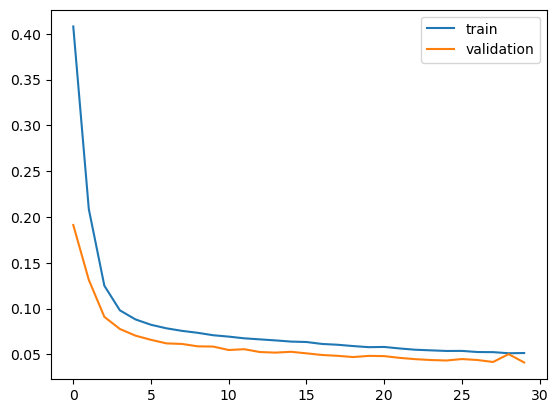

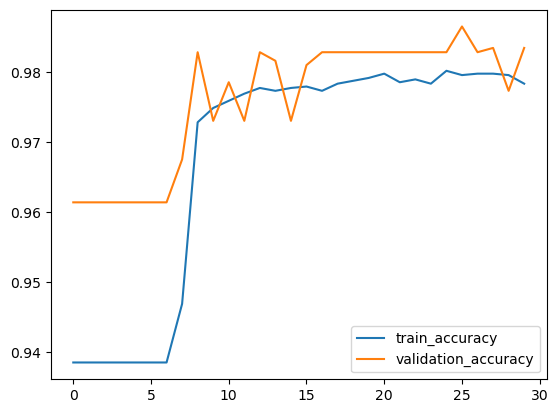

In [12]:
# Use Tensorboard for network visualization & debugging
from tensorflow.keras.callbacks import TensorBoard

# Create directory based on the time of the run (to compare different networks in Tensorboard)
import datetime
now = datetime.datetime.now().strftime("%Y%m%d_%H%M")

# Watch for / or \ while creating a directory --> depending on the OS
tbGraph = TensorBoard(log_dir=f'.\Graph\{now}',
                      histogram_freq=64, write_graph=True, write_images=True)

history = model.fit(X_train_scaled, Y_train, 
          epochs=30, 
          batch_size=32,
          verbose=2,
          validation_data=(X_validation_scaled, Y_validation),
          callbacks=[tbGraph])

### plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

plt.plot(history.history['binary_accuracy'], label='train_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='validation_accuracy')
plt.legend()
plt.show()

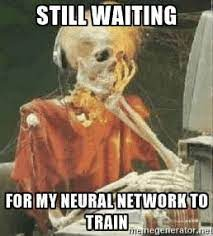 

## Visualize your Network using Tensorboard
We will use the Graph object (tbGraph) created in the previous line to visualize our network in Tensorboard.

Tensorboard makes it easier to understand, debug, and optimize TensorFlow networks, it unfolds the 'black box' to improve the undertainding and evaluation of our model. We can also see the DAGs and the data (or Tensor) flow of our architecture.

To open the Graph object we created, open your terminal or command prompt (including Anaconda prompt) and go to your working directory
<br> `cd my_working_directory`
<br> Activate the environment
<br> `(conda/source) activate DL_Example`
<br> Install typing-extensions package required for tensorbard
<br> `pip install typing-extensions`
<br> Then type command below
<br> `tensorboard --logdir ./Graph`
<br> Now open your web browser and enter the address below
<br> http://localhost:6006

52/52 [==============================] - 0s 1ms/step


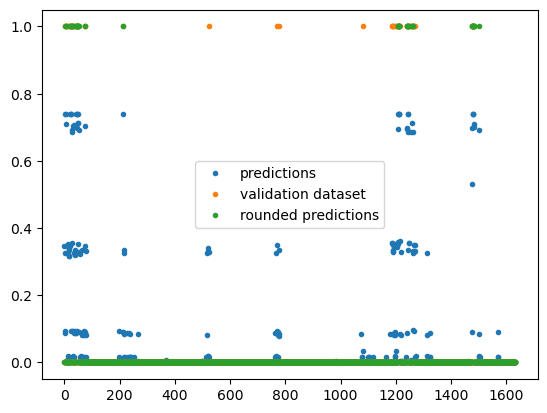

52/52 [==============================] - 0s 1ms/step


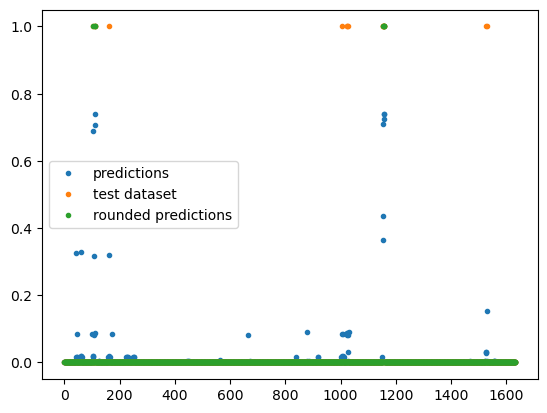

In [13]:
# Let's check the predictions
import matplotlib.pyplot as plt

# calculate predictions for validation dataset
pred_val = model.predict(X_validation_scaled)
rounded_pred_val = [round(x[0]) for x in pred_val]

plt.figure()
plt.plot(pred_val,'.', label = 'predictions')
plt.plot(Y_validation ,'.', label = 'validation dataset') # fill in the validation dataset
plt.plot(rounded_pred_val,'.', label = 'rounded predictions')
plt.legend()
plt.show()

# calculate predictions for test dataset
pred_test = model.predict(X_test_scaled)
rounded_pred_test = [round(x[0]) for x in pred_test]

plt.figure()
plt.plot(pred_test,'.', label = 'predictions')
plt.plot(Y_test ,'.', label = 'test dataset') # fill in the validation dataset
plt.plot(rounded_pred_test,'.', label = 'rounded predictions')
plt.legend()
plt.show()



In [14]:
# Let's try confusion matrix

import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, 
                          fig=None, ax=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[sklearn.utils.multiclass.unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    if not ax:
        fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
                
    fig.tight_layout()
    return ax


Normalized confusion matrix
[[0.99808917 0.00191083]
 [0.38095238 0.61904762]]
Normalized confusion matrix
[[1.     0.    ]
 [0.5625 0.4375]]


C:\Users\tuhf\AppData\Local\Temp\ipykernel_21728\1927192676.py:57: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


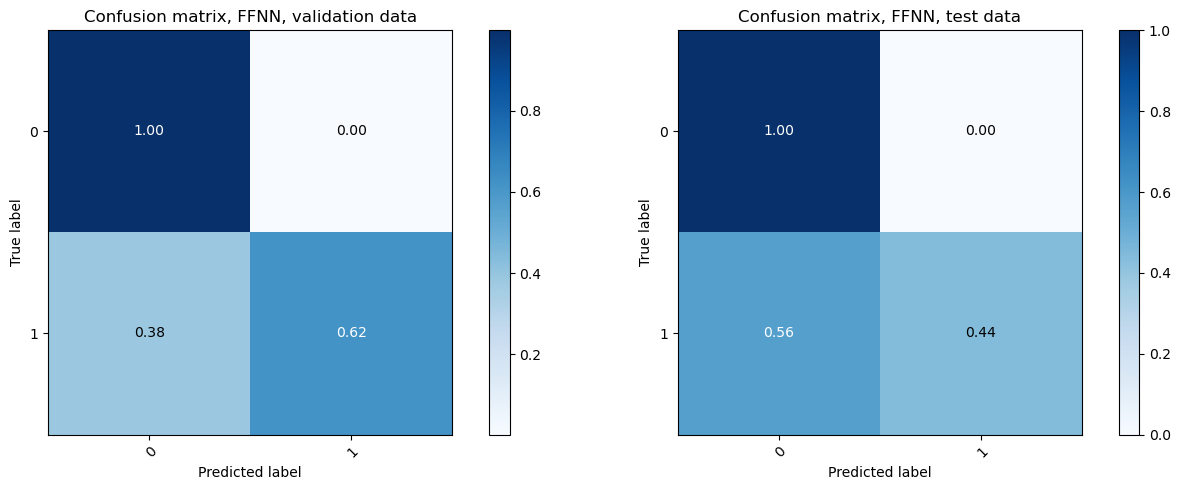

In [15]:
import sklearn.metrics
fig,axs = plt.subplots(1,2, figsize = (14,5))
plot_confusion_matrix(Y_validation, rounded_pred_val, classes=[0,1],
                      normalize = True,
                      title='Confusion matrix, FFNN, validation data',
                      cmap=plt.cm.Blues,
                      fig = fig,ax = axs[0])
plot_confusion_matrix(Y_test, rounded_pred_test, classes=[0,1],
                      normalize = True,
                      title='Confusion matrix, FFNN, test data',
                      cmap=plt.cm.Blues,
                      fig = fig,ax = axs[1])
plt.show()

## Over-fitting Problem
Overfitting can be recognized as **training with high accuracy but performance** ***significantly*** **drops on test/validation dataset** 

There are a few best practices to avoid over-fitting:
   1. ***Get more data*** if possible. As a simple rule of thumb, you should have about 10 times more data than you have weights (or parameters) to fit.
   
   2. ***Regularization*** it is a way to penalize high weights and biases (or both) https://keras.io/regularizers/
   There are three different regularization techniques supported, each provided as a class in the keras.regularizers module:
<br>**l1**: Activity is calculated as the sum of absolute values.
<br>**l2**: Activity is calculated as the sum of the squared values.
<br>**l1_l2**: Activity is calculated as the sum of absolute and sum of the squared values.
<br>Each of the l1 and l2 regularizers takes a single hyperparameter that controls the amount that each activity contributes to the sum. The l1_l2 regularizer takes two hyperparameters, one for each of the l1 and l2 methods. The regularizer class must be imported and then instantiated

   3. ***Early stopping*** by visualizing your training and validation convergence together, you can limit the number epochs to where the 'validation_loss' is minimized.
   
   4. ***Drop-out*** it is randomly deactivating neurons in each epoch (or in each iteration). This way, the neural network takes a ramdom path during training which helps generalization of your model.
   
Let's try a couple of them for our binary classification model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                150       
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 671 (2.62 KB)
Trainable params: 671 (2.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
154/154 - 1s - 

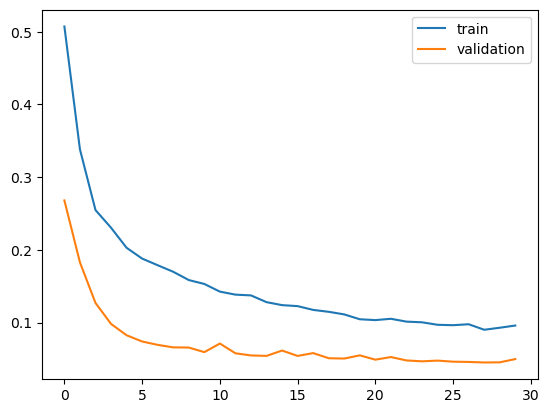

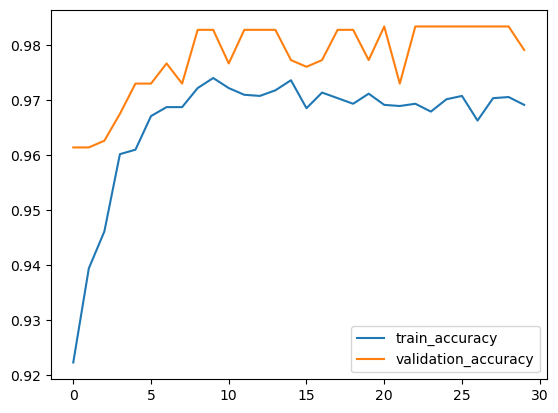

In [16]:
# import regularizer(s)
from tensorflow.keras.regularizers import l1, l2, l1_l2
# import Dropout
from tensorflow.keras.layers import Dropout
# import activation seperately
from tensorflow.keras.layers import Activation

# for multiple model creation - clear  the previous DAG
K.clear_session() 

# create model
model = Sequential()
model.add(Dense(50, 
                input_dim=X_train_scaled.shape[1], 
                kernel_initializer='random_uniform',
                bias_initializer='zeros',
                activity_regularizer='l2')) # we are adding the regularizer directly to the layer
# then we add the activation
model.add(Activation('relu'))
model.add(Dense(10,
                activation='relu'))
# we add Drop-out with a ratio that will put up to 50% of the inputs (to the layer) to zero
model.add(Dropout(0.5))
model.add(Dense(1, 
                activation='sigmoid'))
model.summary()

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

# fit the model and store the graphs and performance to be used in TensorBoard
now = datetime.datetime.now().strftime("%Y%m%d_%H%M")

tbGraph = TensorBoard(log_dir=f'.\Graph\{now}',
                      histogram_freq=64*2, write_graph=True, write_images=True)

history = model.fit(X_train_scaled, Y_train, 
          epochs=30,
          batch_size=32,
          verbose=2,
          validation_data=(X_validation_scaled, Y_validation),
          shuffle = True,
          callbacks=[tbGraph])

### plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

plt.plot(history.history['binary_accuracy'], label='train_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='validation_accuracy')
plt.legend()
plt.show()

# Let's try with LSTM this time!

Since LSTM has a memory - hence a strong dependence on the sequence itself, we should make sure we have a **continuous dataset**

Remember the missing time stamps / periods? We should attend to them now.



In [17]:
dataset_T01_cont.loc[missing_time_stamps]

,Turbine_ID,Amb_WindSpeed_Max,Amb_WindSpeed_Min,Amb_WindSpeed_Avg,Amb_WindSpeed_Std,Rated
2017-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:20:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:40:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2017-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 22:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 22:20:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 22:40:00,NaN,NaN,NaN,NaN,NaN,NaN


## Divide Time series into Sequences

<img src="https://i.ibb.co/Htb5S60/Sequence-sliding-faster.gif" alt="Drawing" style="float: left" /> 
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
We will define 2 useful functions that will generate sequences of input + output intervals.

* The input interval is based on how much further back you would like to add to the memory
* The output interval depends on the forecast horizon for your problem

In our binary classification case, we are not planning to apply any forecast (no prediction, just estimation). Therefore, our output interval will be 1.

The input interval is one of the *hyperparameters* to tune. We can start with an initial guess and adjust it to see if we can get a performance increase.



In [18]:
### define a function that will prepare the shifting input sequences for the network
def forecast_sequences_input(input_data,n_lag):
    """
    A function that will split the input time series to sequences for nowcast/forecast problems
    Arguments:
        input_data: Time series of input observations as a list, NumPy array or pandas series
        n_lag: number of previous time steps to use for training, a.k.a. time-lag        
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = input_data.shape[1] 
    df = pd.DataFrame(input_data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_lag, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg


### define a function that will prepare the shifting output sequences of the network
def forecast_sequences_output(output_data,n_out):
    """
    A function that will split the output time series to sequences for nowcast/forecast problems
    Arguments:
        output_data: Time series of input observations as a list, NumPy array or pandas series
        n_out: forecast horizon (for multi-output forecast)
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = output_data.shape[1] 
    df = pd.DataFrame(output_data)
    cols, names = list(), list()
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names    
    return agg


### Define length of the input and output intervals within the sequences

In [19]:
n_lag = 6 # number of previous time steps to use for training, a.k.a. time-lag
n_out = 1  # forecast horizon [s] 

### Define training, validation and test data as before, let's use dataframes this time

INPUTS:   
   1. Mean Wind Speed $\rightarrow$ **'Amb_WindSpeed_Avg'**
   2. Standard deviation of Wind Speed $\rightarrow$ **'Amb_WindSpeed_Std'**

OUTPUT:
   1. The **'Rated'** class
       1. Below_rated $\rightarrow$ **0**   
       2. Rated $\rightarrow$ **1**  


In [20]:
### Split data into train & test 
train_int = int(0.6*len(dataset_T01)) # 60% of the data length for training
validation_int = int(0.8*len(dataset_T01)) # 20% more for validation

# training input vector
X_train = dataset_T01[['Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std']][:train_int]
X_train = forecast_sequences_input(X_train,n_lag)

# training output vector
Y_train = dataset_T01[['Rated']][:train_int]
Y_train = forecast_sequences_output(Y_train, n_out)

# validation input vector
X_validation = dataset_T01[['Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std']][train_int:validation_int]
X_validation = forecast_sequences_input(X_validation,n_lag)

# validation output vector
Y_validation = dataset_T01[['Rated']][train_int:validation_int]
Y_validation = forecast_sequences_output(Y_validation, n_out)

# test input vector
X_test = dataset_T01[['Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std']][validation_int:]
X_test = forecast_sequences_input(X_test,n_lag)

# test output vector
Y_test = dataset_T01[['Rated']][validation_int:]
Y_test = forecast_sequences_output(Y_test, n_out)


In [21]:
X_train

,var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1)
Timestamp,,,,,,,,,,,,
2017-01-01 01:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.08,0.09
2017-01-01 02:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.08,0.09,8.02,1.02
2017-01-01 03:30:00,NaN,NaN,NaN,NaN,NaN,NaN,5.08,0.09,8.02,1.02,7.07,0.09
2017-01-01 04:00:00,NaN,NaN,NaN,NaN,5.08,0.09,8.02,1.02,7.07,0.09,8.01,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11 05:40:00,10.05,1.07,8.09,2.00,9.06,2.01,9.09,2.01,10.09,2.06,11.07,2.02
2017-08-11 06:00:00,8.09,2.00,9.06,2.01,9.09,2.01,10.09,2.06,11.07,2.02,12.05,2.02
2017-08-11 06:50:00,9.06,2.01,9.09,2.01,10.09,2.06,11.07,2.02,12.05,2.02,12.06,2.01


In [22]:
Y_train

,var1(t)
Timestamp,
2017-01-01 01:50:00,0
2017-01-01 02:30:00,0
2017-01-01 02:50:00,0
2017-01-01 03:30:00,0
2017-01-01 04:00:00,0
...,...
2017-08-11 05:40:00,0
2017-08-11 06:00:00,0
2017-08-11 06:50:00,0


### Remember to scale!

In [23]:
### scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

print('Training input (samples, timesteps):', X_train_scaled.shape)
print('Training output (samples, timesteps):', Y_train.shape)
print('Validation input (samples, timesteps):', X_validation_scaled.shape)
print('Validation output (samples, timesteps):', Y_validation.shape)

Training input (samples, timesteps): (4899, 12)
Training output (samples, timesteps): (4899, 1)
Validation input (samples, timesteps): (1633, 12)
Validation output (samples, timesteps): (1633, 1)


C:\Users\tuhf\AppData\Local\anaconda3\envs\DL_example\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\tuhf\AppData\Local\anaconda3\envs\DL_example\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\tuhf\AppData\Local\anaconda3\envs\DL_example\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\tuhf\AppData\Local\anaconda3\envs\DL_example\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_

### Pad NaNs for missing periods with a significant number (to be 'masked' for the training later)

In [24]:
pad_value = 999

X_train_scaled[np.isnan(X_train_scaled)] = pad_value
X_validation_scaled[np.isnan(X_validation_scaled)] = pad_value
X_test_scaled[np.isnan(X_test_scaled)] = pad_value

## LSTM architecture

We will first add a Masking layer to tell the network to ignore missing periods in the training
 
We will use pretty much the same architecture with FFNN, except for the LSTM layers. 

There are however, little differences LSTM requires in bulding the model.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 2)           0         
                                                                 
 lstm (LSTM)                 (None, None, 50)          10600     
                                                                 
 activation (Activation)     (None, None, 50)          0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                2440      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 13051 (50.98 KB)
Trainable params: 13051 (50.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
77/77 - 6

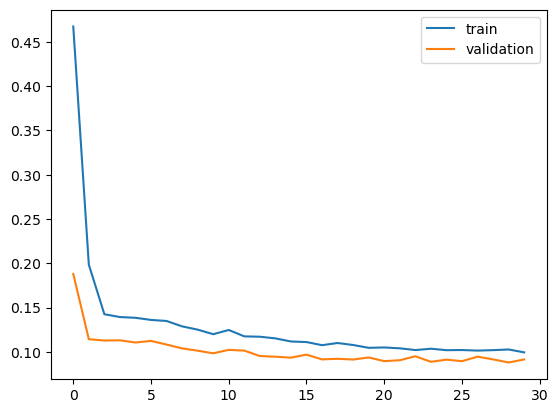

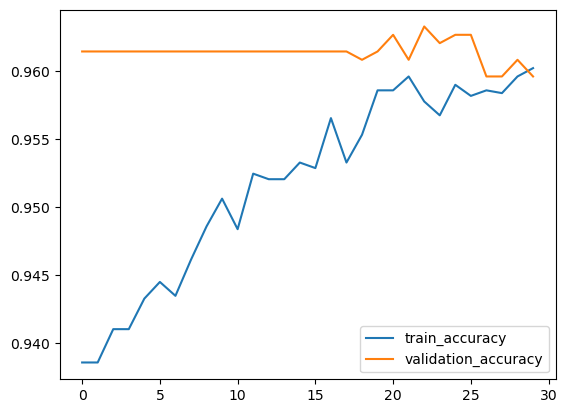

In [25]:
from tensorflow.keras.layers import LSTM, Masking

# for multiple model creation - clear  the previous DAG
K.clear_session() 

### Input reshape for LSTM problem  [samples, timesteps, features]
no_features = 2 # Avg and Std of wind speed

train_X = X_train_scaled.reshape((X_train_scaled.shape[0], n_lag, no_features))#.astype('float32')
train_Y = Y_train.values#.astype('float32')

validation_X = X_validation_scaled.reshape((X_validation_scaled.shape[0], n_lag, 2))#.astype('float32')
validation_Y = Y_validation.values#.astype('float32')

test_X = X_test_scaled.reshape((X_test_scaled.shape[0], n_lag, 2))#.astype('float32')
test_Y = Y_test.values#.astype('float32')

### create model
model = Sequential()

# Masking layer (for the pad_value)
model.add(Masking(mask_value=pad_value, input_shape=(None, no_features)))

# First LSTM layer
model.add(LSTM(50, 
               return_sequences=True,  # important to add it to ensure the following LSTM layers will have the same input shape
               input_shape=(train_X.shape[1], train_X.shape[2]),                
               kernel_initializer='random_uniform',
               bias_initializer='zeros'))
               
# then we add the activation
model.add(Activation('relu'))

# Second LSTM layer
model.add(LSTM(10, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))
model.summary()

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

# fit the model and store the graphs and performance to be used in TensorBoard (optional)
now = datetime.datetime.now().strftime("%Y%m%d_%H%M")

tbGraph = TensorBoard(log_dir=f'.\Graph\{now}',
                      histogram_freq=64*2, write_graph=True, write_images=True)

history = model.fit(train_X, train_Y, 
          epochs=30,
          batch_size=64,
          verbose=2,
          validation_data=(validation_X, validation_Y),
          callbacks=[tbGraph])

### plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

plt.plot(history.history['binary_accuracy'], label='train_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='validation_accuracy')
plt.legend()
plt.show()

# Let's try GRUs - Same 3D inputs!

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, None, 2)           0         
                                                                 
 gru (GRU)                   (None, None, 50)          8100      
                                                                 
 activation_1 (Activation)   (None, None, 50)          0         
                                                                 
 gru_1 (GRU)                 (None, 10)                1860      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9971 (38.95 KB)
Trainable params: 9971 (38.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
77/77 - 9

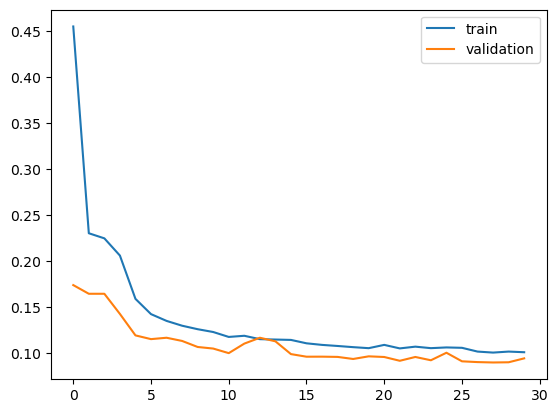

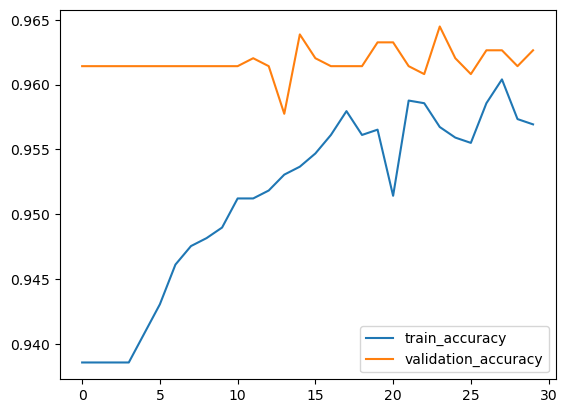

In [26]:
from tensorflow.keras.layers import GRU

### create model
model = Sequential()

# Masking layer (for the pad_value)
model.add(Masking(mask_value=pad_value, input_shape=(None, no_features)))

# First GRU layer
model.add(GRU(50, 
               return_sequences=True,  # important to add it to ensure the following LSTM layers will have the same input shape
               input_shape=(train_X.shape[1], train_X.shape[2]),                
               kernel_initializer='random_uniform',
               bias_initializer='zeros'))
               
# then we add the activation
model.add(Activation('relu'))

# Second GRU layer
model.add(GRU(10, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))
model.summary()

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

# fit the model and store the graphs and performance to be used in TensorBoard (optional)
now = datetime.datetime.now().strftime("%Y%m%d_%H%M")

tbGraph = TensorBoard(log_dir=f'.\Graph\{now}',
                      histogram_freq=64*2, write_graph=True, write_images=True)

history = model.fit(train_X, train_Y, 
          epochs=30,
          batch_size=64,
          verbose=2,
          validation_data=(validation_X, validation_Y),
          callbacks=[tbGraph])

### plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

plt.plot(history.history['binary_accuracy'], label='train_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='validation_accuracy')
plt.legend()
plt.show()

# What about a cocktail? LSTM + GRU Combo!

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, None, 2)           0         
                                                                 
 gru_2 (GRU)                 (None, None, 50)          8100      
                                                                 
 activation_2 (Activation)   (None, None, 50)          0         
                                                                 
 lstm_2 (LSTM)               (None, 10)                2440      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 10551 (41.21 KB)
Trainable params: 10551 (41.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
154/154

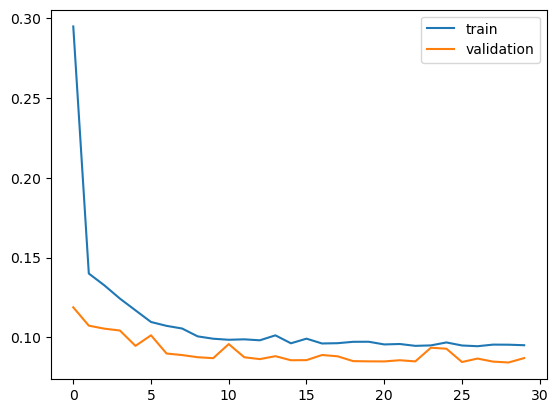

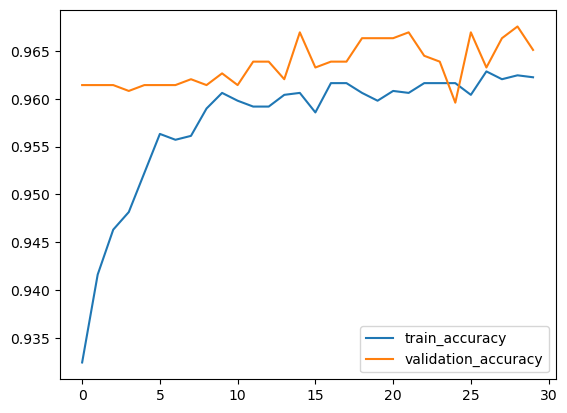

In [27]:
### create model
model = Sequential()

# Masking layer (for the pad_value)
model.add(Masking(mask_value=pad_value, input_shape=(None, no_features)))

# First is a GRU layer
model.add(GRU(50, 
               return_sequences=True,  # important to add it to ensure the following LSTM layers will have the same input shape
               input_shape=(train_X.shape[1], train_X.shape[2]),                
               kernel_initializer='random_uniform',
               bias_initializer='zeros'))
               
# then we add the activation
model.add(Activation('relu'))

# Second is an LSTM layer
model.add(LSTM(10, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))
model.summary()

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

# fit the model and store the graphs and performance to be used in TensorBoard (optional)
now = datetime.datetime.now().strftime("%Y%m%d_%H%M")

tbGraph = TensorBoard(log_dir=f'.\Graph\{now}',
                      histogram_freq=64*2, write_graph=True, write_images=True)

history = model.fit(train_X, train_Y, 
          epochs=30,
          batch_size=32,
          verbose=2,
          validation_data=(validation_X, validation_Y),
          callbacks=[tbGraph])

### plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

plt.plot(history.history['binary_accuracy'], label='train_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='validation_accuracy')
plt.legend()
plt.show()

## Additional info on the time series processing - things to watch out!
1. **Non-stationary data** 
<br>‘Stationarity’ is one of the most important concepts you will come across when working with time series data. A stationary series is one in which the properties – mean, variance and covariance, **do not** vary with time.
<br>  Always keep in mind that in order to use time series forecasting models, it is necessary to convert any non-stationary series to a stationary series first. There are mainly two ways to do this:
     <br> 1.1 ***Differencing (one or multiple steps)***   $\rightarrow y_{diff}=y_{t}-y_{t-n} $ Pandas diff can directly be used or you can use df.shift(n) to extract $y_{t-n}$ 
     <br> 1.2 ***Axis transformations*** $\rightarrow$ e.g. log-transform can also help depending on your data. Also note that you can repeat the differencing several times until you reach the 'desired' stationarity.
2. **Scaling**
<br>As discussed (and demonstrated) above.
3. **LSTM particular input shape**
<br> Think thorough on samples, timesteps, features and what they represent for your data and problem at hand. In general, it goes as "how many features you would like to feed into the model at a time (timesteps) and how many of those sequences do you have? Let's do an example for our forecasting problem at hand...
3. **Inverse transform the output**
<br> Different than 'just' a binary classification, the output of your model might have units and non-stationary structure as well. Remember to inverse transform of your model predictions to deliver the 'true value' of your outputs.